<a href="https://colab.research.google.com/github/mounishvatti/machine-learning/blob/main/Core_Learning_Algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFLow Core Learning Algoritms

**The algorithms include:**

*   Linear Regresion
*   Classification
*   Clustering
*   Hidden Markov Models

# 1. Linear Regression

Most basic forms of machine learning and is used to predict numeric values.

In this tutorial we will use a linear model to predict the survival rate of passangers from the titanic dataset.


# How it works

Linear regression follows a very simple concept. If the data points are related linearly we can generate a line of best fit for these points and use it to predict future values.

y = mx + b

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf

In [7]:
# load dataset
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived') # removing the survived column from the dataframe
y_eval = dfeval.pop('survived')

CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []

for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique()  # gets a list of all unique values from given feature column
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

print(feature_columns)

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.string, def

In [8]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


<Axes: >

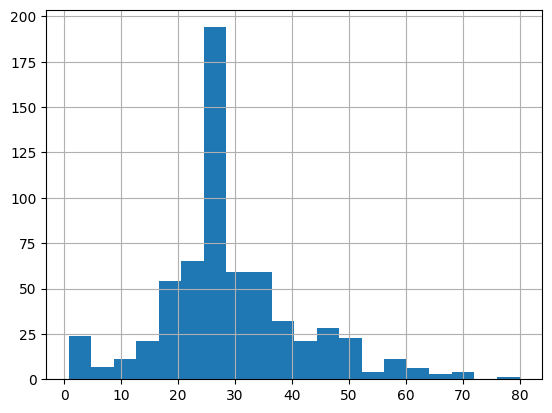

In [ ]:
dftrain.age.hist(bins=20)

<Axes: ylabel='sex'>

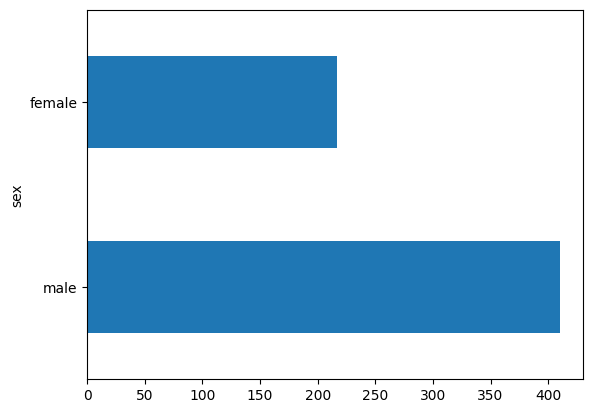

In [ ]:
dftrain.sex.value_counts().plot(kind='barh')

<Axes: ylabel='class'>

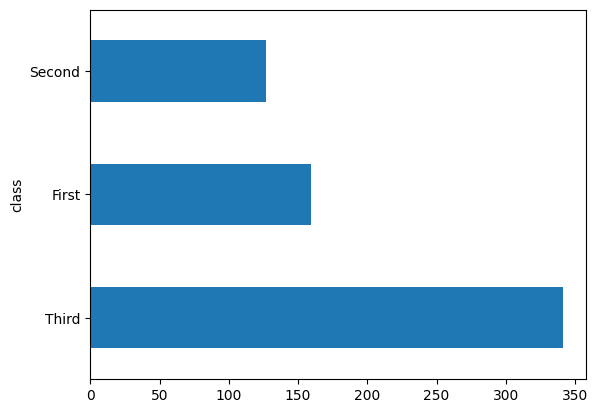

In [ ]:
dftrain['class'].value_counts().plot(kind = 'barh')

Text(0.5, 0, '% survive')

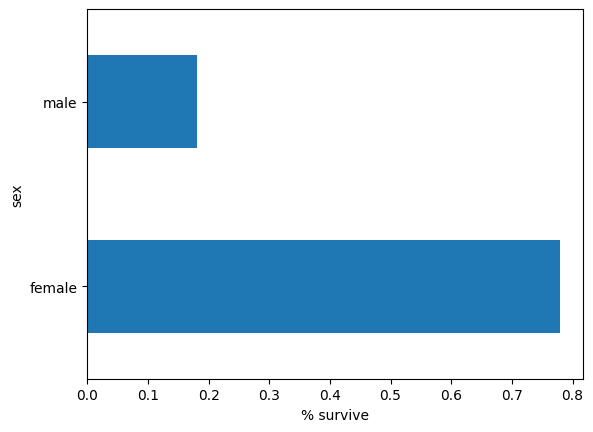

In [ ]:
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')

In [11]:
# training the data - feeding the model the data from the dataset
# loaded in the form of batches (in case of large datasets)
# epochs - amount of times the model sees the data

def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():  # inner function, this will be returned
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  # create tf.data.Dataset object with data
    if shuffle:
      ds = ds.shuffle(1000)  # randomize order of data

    ds = ds.batch(batch_size).repeat(num_epochs)  # split dataset into batches of 32 and repeat process for number of epochs
    return ds  # return a batch of the dataset
  return input_function  # return a function object for use

train_input_fn = make_input_fn(dftrain, y_train)  # here we will call the input_function that was returned to us to get a dataset object we can feed to the model
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)


linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
# We create a linear estimtor by passing the feature columns we created earlier

linear_est.train(train_input_fn)  # train
result = linear_est.evaluate(eval_input_fn)  # get model metrics/stats by testing on t

clear_output()  # clears console output
print("Accuracy: ",result['accuracy'])  # the result variable is simply a dict of stats about our model


Accuracy:  0.7651515


In [14]:
results = list(linear_est.predict(eval_input_fn))
print(results[0])

{'logits': array([-2.8414433], dtype=float32), 'logistic': array([0.05512531], dtype=float32), 'probabilities': array([0.9448747 , 0.05512531], dtype=float32), 'class_ids': array([0]), 'classes': array([b'0'], dtype=object), 'all_class_ids': array([0, 1], dtype=int32), 'all_classes': array([b'0', b'1'], dtype=object)}


# 2. Classification

Used to separate data points into classes of different labels

Ex: Decision Tree, Random Forest

In [2]:
CSV_COLUMN_NAMES = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth', 'Species']
SPECIES = ['Setosa', 'Versicolor', 'Virginica']
# Lets define some constants to help us later on

train_path = tf.keras.utils.get_file(
    "iris_training.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv")
test_path = tf.keras.utils.get_file(
    "iris_test.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv")

train = pd.read_csv(train_path, names=CSV_COLUMN_NAMES, header=0)
test = pd.read_csv(test_path, names=CSV_COLUMN_NAMES, header=0)

573/573 [==============================] - 0s 0us/step


In [3]:
train.head()

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
0,6.4,2.8,5.6,2.2,2
1,5.0,2.3,3.3,1.0,1
2,4.9,2.5,4.5,1.7,2
3,4.9,3.1,1.5,0.1,0
4,5.7,3.8,1.7,0.3,0


In [4]:
train_y = train.pop('Species')
test_y = test.pop('Species')
train.head() # the species column is now gone

,SepalLength,SepalWidth,PetalLength,PetalWidth
0,6.4,2.8,5.6,2.2
1,5.0,2.3,3.3,1.0
2,4.9,2.5,4.5,1.7
3,4.9,3.1,1.5,0.1
4,5.7,3.8,1.7,0.3


In [5]:

def input_fn(features, labels, training=True, batch_size=256):
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))

    # Shuffle and repeat if you are in training mode.
    if training:
        dataset = dataset.shuffle(1000).repeat()

    return dataset.batch(batch_size)


In [7]:

my_feature_columns = []

for key in train.keys():
    my_feature_columns.append(tf.feature_column.numeric_column(key=key))

print(my_feature_columns)


[NumericColumn(key='SepalLength', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='SepalWidth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='PetalLength', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='PetalWidth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]


# Building a model

In [9]:
# Building a DNN with 2 hidden layers with 30 and 10 hidden nodes each.
classifier = tf.estimator.DNNClassifier(
    feature_columns=my_feature_columns,
    # Two hidden layers of 30 and 10 nodes respectively
    hidden_units=[30, 10],
    # The model must choose between 3 classes.
    n_classes=3)


In [11]:

classifier.train(
    input_fn=lambda: input_fn(train, train_y, training=True),
    steps=5000)


Instructions for updating:
Use standard file utilities to get mtimes.


In [12]:
eval_result = classifier.evaluate(input_fn=lambda: input_fn(test, test_y, training=False))

print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))

Instructions for updating:
Use tf.keras instead.



Test set accuracy: 0.967



In [13]:

def input_fn(features, batch_size=256):
    # Convert the inputs to a Dataset without labels.
    return tf.data.Dataset.from_tensor_slices(dict(features)).batch(batch_size)

features = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth']
predict = {}

print("Please type numeric values as prompted.")

for feature in features:
  valid = True
  while valid:
    val = input(feature + ": ")
    if not val.isdigit(): valid = False

  predict[feature] = [float(val)]

predictions = classifier.predict(input_fn=lambda: input_fn(predict))
for pred_dict in predictions:
    class_id = pred_dict['class_ids'][0]
    probability = pred_dict['probabilities'][class_id]

    print('Prediction is "{}" ({:.1f}%)'.format(
        SPECIES[class_id], 100 * probability))


Please type numeric values as prompted.
SepalLength: 2.4
SepalWidth: 2.6
PetalLength: 6.5
PetalWidth: 6.3


Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.


Prediction is "Virginica" (99.8%)


# 3. Clustering - (Unsupervised)

K-Means clustering

Finds the clusters of data

# 4. Hidden Markov Models

Finite set of states, each of which is associated with a (generally multidimensional) probability distribution.

**States:** In each markov model we have finite set of states. These states could be something like "warm" and cold", "high" and "low". These states are hidden inside the model and we do not directly observe them.

**Observations:** Each state has a particular outcome or observation associated with it based on probability distribution.

An example of this is: *On a hot day Tim has a 80% chance of being happy and 20% of being sad.*

**Transitions:** Each state will have a probability defining the likelyhood of transitioning to a different state.

**Ex:** *A cold day has 30% chance of being followed by a hot day and a 70% chance of being followed by another cold day.*



In [18]:
import tensorflow_probability as tfp  # We are using a different module from tensorflow this time
import tensorflow as tf

In [19]:
tfd = tfp.distributions  # making a shortcut for later on
initial_distribution = tfd.Categorical(probs=[0.2, 0.8])
transition_distribution = tfd.Categorical(probs=[[0.5, 0.5],
                                                 [0.2, 0.8]])

observation_distribution = tfd.Normal(loc=[0., 15.], scale=[5., 10.])

# the loc argument represents the mean and the scale is the standard devitation

In [20]:
model = tfd.HiddenMarkovModel(
    initial_distribution=initial_distribution,
    transition_distribution=transition_distribution,
    observation_distribution=observation_distribution,
    num_steps=7)

In [21]:
mean = model.mean()

with tf.compat.v1.Session() as sess:
  print(mean.numpy())

[11.999999 11.1      10.830001 10.748999 10.724699 10.71741  10.715222]
